In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import json
from ipywidgets import IntSlider, interact
from scipy import stats
import geopandas as gpd
import pandas_bokeh
from bokeh.plotting import figure, output_file, save
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import umap

# Analysis of fertilizer efficiency on agriculture production
## Handling data
First lets import the 2 dataset from FAO :
* One about agriculture production containing (among others data) the yield per crops and per country : Crops from http://www.fao.org/faostat/en/#data/QC
* The other about fertilizer containing quantity used of 3 different fertilizers per area of cropland (from 2002 to 2016): Fertilizers indicators from http://www.fao.org/faostat/en/#data/EF 

In [3]:
#importing needed FAO datasets
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

### 1) Fertilizer
Let's take a look at the fertilizer dataset and the type of data it contains

In [4]:
fertilizer_area.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2003,2003,kg/ha,2.57,Fc
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2004,2004,kg/ha,2.96,Fc


In [5]:
# range of year covered by fertilizer dataframe
mini=min(fertilizer_area.Year)
maxi=max(fertilizer_area.Year)
print('Period of time covered by fertilizer_area : %d to %d'%(mini,maxi))

Period of time covered by fertilizer_area : 2002 to 2016


In [6]:
# different types of fertilizers (and associated codes)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [7]:
# number of countries in the dataset
fertilizer_area.Area.unique().size

197

In [8]:
# Checking the presence of missing values
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


So far, we don't observe any missing values.

However, as we will do an analysis over the years, let's take a look at the pivoted dataframe for the first nutrient (nitrogen) :


In [9]:
ferti_corr=(fertilizer_area 
        .query('`Item Code` ==3102')
        .pivot(index='Area',columns='Year',values='Value')
          )
print(ferti_corr.shape[0])
ferti_corr.head()

197


Year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,3.02,2.57,2.96,3.17,6.20,3.57,2.94,4.45,4.19,6.31,27.58,14.45,11.71,11.71,11.71
Africa,11.37,12.49,12.98,12.63,11.34,11.19,12.83,11.21,13.42,12.49,11.99,13.34,14.27,13.37,14.11
Albania,54.34,53.15,51.19,55.94,42.57,44.38,40.39,48.13,48.48,52.74,49.95,44.11,44.13,52.87,60.98
Algeria,3.42,2.07,12.62,0.49,5.23,4.37,2.75,5.69,8.43,7.51,7.89,7.79,12.25,11.83,11.53
Americas,44.75,48.24,47.61,46.88,48.52,52.89,48.92,49.66,53.46,60.11,59.68,59.44,58.48,57.26,60.90


It is possible that pivoting of dataframe had created some missing values (value of a country missing for one year), thus let's look at it :

In [10]:
# Checking in which columns values are missing for 1 year
print(ferti_corr.isnull().sum())



Year
2002    19
2003    14
2004    10
2005    10
2006    10
2007    10
2008    10
2009     8
2010     8
2011     8
2012     4
2013     3
2014     3
2015     3
2016     4
dtype: int64


From the previous table, we can see that some values are missing for each year(nitrogen nutrient). 
We can see that more values are missing for older years and that there are less than 10% of the values (197 countries) missing.
Thus interpolation could be a method to fill these missing values.

However, in order to execute a linear interpolation we need to see if the evolution could effectively be interpolated by a linear function :

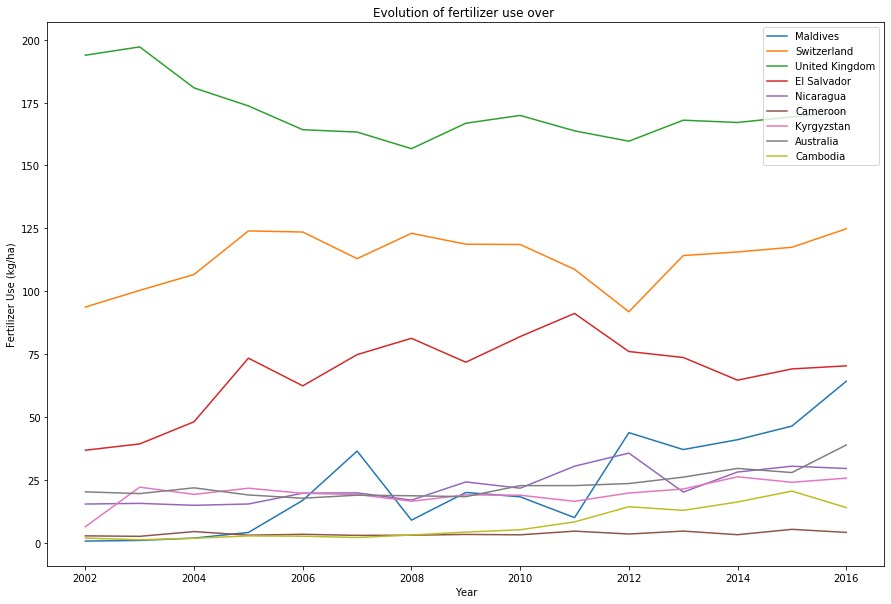

In [11]:
# Visual check of fertilizer evolution over the years
fig = plt.figure(figsize = (15, 10))
for area in fertilizer_area.sample(n=10).Area.unique()[:10]:
    a=fertilizer_area.query('Area == @area and `Item Code`==3102')
    x=a.Year
    y=a.Value
    plt.plot(x,y, label = area)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Fertilizer Use (kg/ha)')
    plt.title('Evolution of fertilizer use over ')

The previous plot confrime that ferlizers can be interpolated using linear function as the order of magnitude stay the same ans look quite linear.

So lets do that interpolation (we don't do it on countries which have more than half the years missing and drop them instead):

In [12]:
# Create a dataframe containing Area Code corresponding to each area
area_df=fertilizer_area.loc[:,['Area','Area Code']]
area_df.drop_duplicates(inplace=True)

# We need to do the interpolation for each fertilizer :
fertilizer_updated=pd.DataFrame()
for code in ferti_items['Item Code'].values:
    ferti_corr=(fertilizer_area 
            .query('`Item Code` ==@code')
            .pivot(index='Area',columns='Year',values='Value')
              )
    ferti_corr.interpolate(method='linear', 
                           axis=1, limit=7 ,
                           inplace=True, 
                           limit_direction='both')
    ferti_corr.dropna(inplace=True)
    ferti_corr.reset_index(inplace=True)
    ferti_corr=pd.melt(ferti_corr,
                        id_vars='Area',
                        value_vars=list(ferti_corr.columns[1:]),
                        var_name='Year', 
                        value_name='Value')
    ferti_corr['Item Code']=code
    ferti_corr['Item']=ferti_items.query('`Item Code`== @code').Item.iloc[0]
    ferti_corr['Year Code']=ferti_corr.Year
    ferti_corr=pd.merge(ferti_corr, area_df, on='Area')
    fertilizer_updated=fertilizer_updated.append(ferti_corr)

fertilizer_updated.reset_index(inplace=True)
fertilizer_updated.drop(columns=['index'],axis=1,inplace=True)
fertilizer_updated.head()

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2


In [13]:
# Checking if there is still some missing values
ferti_corr2=(fertilizer_updated 
        .query('`Item Code` ==3102')
        .pivot(index='Area',columns='Year',values='Value')
          )
print(ferti_corr2.isnull().sum())

Year
2002    0
2003    0
2004    0
2005    0
2006    0
2007    0
2008    0
2009    0
2010    0
2011    0
2012    0
2013    0
2014    0
2015    0
2016    0
dtype: int64


In [14]:
#Updating the main fertilizer dataset
fertilizer_area=fertilizer_updated
fertilizer_area

,Area,Year,Value,Item Code,Item,Year Code,Area Code
0,Afghanistan,2002,3.02,3102,Nutrient nitrogen N (total),2002,2
1,Afghanistan,2003,2.57,3102,Nutrient nitrogen N (total),2003,2
2,Afghanistan,2004,2.96,3102,Nutrient nitrogen N (total),2004,2
3,Afghanistan,2005,3.17,3102,Nutrient nitrogen N (total),2005,2
4,Afghanistan,2006,6.20,3102,Nutrient nitrogen N (total),2006,2
...,...,...,...,...,...,...,...
8515,Zimbabwe,2012,2.93,3104,Nutrient potash K2O (total),2012,181
8516,Zimbabwe,2013,3.66,3104,Nutrient potash K2O (total),2013,181
8517,Zimbabwe,2014,4.93,3104,Nutrient potash K2O (total),2014,181
8518,Zimbabwe,2015,4.73,3104,Nutrient potash K2O (total),2015,181


## 2) Crop dataset
We used grouped yields to reduce risks of collinearity in the dataset (grouped crops are more likely to regroup all dependent features together).

First, let's take a look at the yields for each country in 2004 (arbitrarily selected):


In [15]:
#extraction of yield in crop dataset and pivot to have a dataframe with yields as columns (features) and countries as rows
crop_corr=(crops.query('`Element Code` == 5419') #The element code of yield is 5419
        .query('`Year Code` == 2004')
        .query('`Item Code` >1000') #grouped yields correspond to item codes > 1000
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
print(crop_corr.shape) #244 countries and (13-1) 12 yields
crop_corr.head()

(244, 13)


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


We can see that there are some missing value (either due to missing values in the crops dataset or to unproduced crops by a country).
How many are there?

In [16]:
# Checking how many values are missing by crop in 2004
print(crop_corr.isnull().sum()[crop_corr.isnull().sum()!=0])

Item
Cereals (Rice Milled Eqv)     27
Cereals,Total                 27
Citrus Fruit,Total            72
Coarse Grain, Total           31
Fibre Crops Primary           90
Fruit Primary                  6
Oilcrops, Cake Equivalent     18
Oilcrops, Oil Equivalent      16
Pulses,Total                  39
Roots and Tubers,Total         7
Treenuts,Total               100
Vegetables Primary             6
dtype: int64


We can expand that analysis for all years:

In [17]:
# count total of missing values for all years
miss_count=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year = (crops.query('`Element Code` == 5419') #creates the dataframe containing yields for the considered year
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area Code',columns='Item',values='Value')
        .reset_index()
          )
    keys = ['Total_row'] + crop_year.columns.values.tolist()
    values = [crop_year.shape[0]] + crop_year.isnull().sum().values.tolist()
    dictionary = dict(zip(keys, values))
    df = pd.DataFrame.from_records([dictionary])
    miss_count = miss_count.append(df,sort=False)
miss_count.sum()

Total_row                    3149.0
Area Code                       0.0
Cereals (Rice Milled Eqv)     389.0
Cereals,Total                 389.0
Citrus Fruit,Total           1063.0
Coarse Grain, Total           448.0
Fibre Crops Primary          1154.0
Fruit Primary                  88.0
Oilcrops, Cake Equivalent     229.0
Oilcrops, Oil Equivalent      194.0
Pulses,Total                  554.0
Roots and Tubers,Total        103.0
Treenuts,Total               1486.0
Vegetables Primary             88.0
dtype: float64

Treenuts, Fibre Crops Primary and Citrus Fruit,Total presents 3703 missing values, 60% of the total number of missing values.

### Interpolating missing value 
1) creating a dataset pointing to missing values and another with all missing value dropped

In [18]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [19]:
ferti_range=pd.Series(range(2002,2016+1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()
        

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [20]:
missing_values.shape[0]

2807

In [21]:
#NCreating the 2nd dataset
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

2) Executing the interpolation

In [22]:
'''count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x').Item.unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value = poly(year)
                template = (dropnan_crops.query('`Area Code` == @x')
                                        .query('`Item` == @j').head(1))
                to_add = template.values
                to_add[0][9] = interp_value
                to_add[0][6] = year
                to_add[0][7] = year
                to_add=pd.DataFrame(to_add, columns=template.columns.values)
                crops=crops.append(to_add, ignore_index=True, sort=False)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print("The operation replaced %d values"%count)
'''

'count=0\n#Purpose of this code : adding missing value by interpolation \nfor x in missing_values[\'Area Code\'].unique():\n    for j in missing_values.query(\'`Area Code` == @x\').Item.unique():\n        if dropnan_crops.query(\'`Area Code` == @x\').query(\'`Item` == @j\').shape[0]>=5 : # That condition is set to avoid replacing value for countries with not enough values\n            interpolation_coef = np.polyfit(dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Year,\n                                            dropnan_crops.query(\'`Area Code` == @x\').query(\'Item == @j\').Value,\n                                            1)\n            poly = np.poly1d(interpolation_coef)\n            for year in missing_values.query(\'`Area Code` == @x\').query(\'`Item` == @j\').Year.values:\n                interp_value = poly(year)\n                template = (dropnan_crops.query(\'`Area Code` == @x\')\n                                        .query(\'`Item` == @j\').head(1)

#### Saving modified crops to avoid re-running the interpolation

In [23]:
#crops.to_pickle("crops_interpolated") # uncomment to save again into pickle

In [24]:
crops=pd.read_pickle("crops_interpolated")

In [25]:
# To avoid duplicated index or other index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


3) Checking changed values 

In [26]:
area_indexed2=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed2.shape[0]-area_indexed.shape[0]

1371

In [27]:
ferti_range=pd.Series(range(2002,2016+1))
missing_values2=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed2.index.get_level_values(level=0).unique().values:
    for item in area_indexed2.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed2.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values2 =missing_values2.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values2.head()

,Area Code,Item,Year
0,11,"Treenuts,Total",2002
1,11,"Treenuts,Total",2003
2,11,"Treenuts,Total",2004
3,11,"Treenuts,Total",2005
4,11,"Treenuts,Total",2006


In [28]:
miss_count2=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Total_row']+crop_year.columns.values.tolist()
    values=[crop_year.shape[0]]+np.round(crop_year.isnull().sum().values).tolist()
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count2=miss_count2.append(df, sort=False)
miss_count2.sum()



Total_row                    3184
Area                            0
Cereals (Rice Milled Eqv)     390
Cereals,Total                 390
Citrus Fruit,Total           1065
Coarse Grain, Total           450
Fibre Crops Primary          1346
Fruit Primary                  90
Oilcrops, Cake Equivalent     279
Oilcrops, Oil Equivalent      234
Pulses,Total                  555
Roots and Tubers,Total        105
Treenuts,Total               1500
Vegetables Primary             90
dtype: int64

In [29]:
miss_count

,Total_row,Area Code,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,209,0,26,26,72,30,87.0,6,18.0,16.0,38,7,101,6
0,209,0,26,26,72,30,87.0,6,18.0,16.0,37,7,101,6
0,209,0,26,26,70,30,87.0,6,18.0,16.0,37,7,99,6
0,209,0,26,26,70,30,87.0,6,18.0,16.0,37,7,99,6
0,210,0,27,27,71,30,90.0,6,18.0,15.0,37,7,99,6
0,210,0,26,26,71,30,89.0,6,18.0,15.0,37,7,99,6
0,210,0,26,26,71,30,90.0,6,18.0,15.0,37,7,98,6
0,210,0,26,26,71,30,89.0,6,18.0,15.0,37,7,98,6
0,210,0,26,26,71,30,89.0,6,17.0,14.0,37,7,98,6
0,210,0,26,26,71,30,89.0,6,17.0,14.0,37,7,98,6


In [30]:
miss_count2

,Total_row,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,213,0,26,26,71,30,89,6,19,16,37,7,100,6
0,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,213,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6
0,212,0,26,26,71,30,90,6,19,16,37,7,100,6


One can notice from the first table that there were 3 columns with NaN value. By construction it's due to the fact there werent any data for these crops for 2015 and 2016. The interpolation program extrapolated for these two years thus allowing us to carry out machine learning on all years. Having the same number of features for each year will also allow us to compare the results between years after having executed post-processing operations.

### Correlation between crops production

For an efficient use of machine learning algorithms, it is also needed to have independant features. Therefore, let's take a look at the correlation heatmap between features :

Text(0.5, 1, 'Correlation matrix of the yields of the dataset')

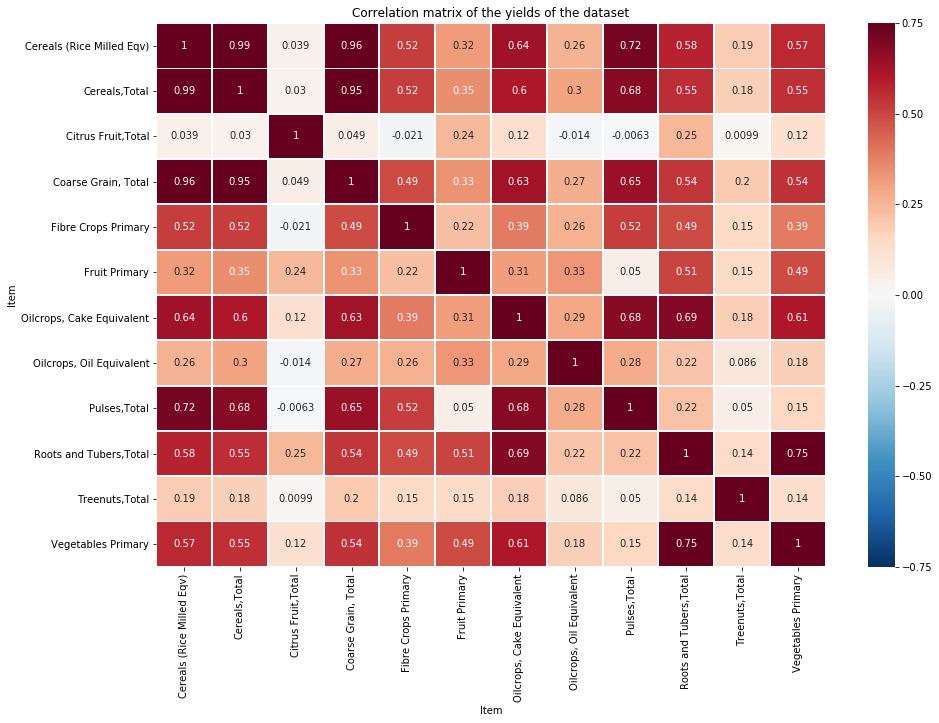

In [31]:
# We did corelation on one year
correlation = crop_corr.corr()

# Plotting correlation map
plt.figure(figsize=(15,10))
heatmap = sns.heatmap(correlation, annot=True, linewidths=1, center=0,\
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
plt.title("Correlation matrix of the yields of the dataset")

It can be observed that cereals are strongly correlated. It is therefore necessary to merge them.
One can also notice that except citrus, there isn't any features negatively correlated to one another which seems consistent with agriculture.


## Dimensionality reduction 


In order to observe the impact of fertilizers on agriculture. It is necessary to compute an indicator of that performance. Dimensionality reduction on yield for each crop and each country will compute an indicator (best explaining the difference between all yields of each country).

2 different algorithms for dimensionality reduction will be used :
* Umap because it can capture non-linear relations
* PCA because it gives us informations about the importance of each feature through coefficients


### Umap reduction

In [32]:
# This function separates countries in tree different groups according to their fertilizer's use
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizers values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

Definition ot the function calculating the umap reduction :

Inputs : year, 1 fertilizer and for 1 or more final dimension(s).

Outputs : computed year, a dataframe with Umap score as well as fertilizer value for each ountry and coeficcient from a linear interpolation of the result (fertilizer value vs umap score)


In [33]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .query('Value > 0')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Now that functions are defined, let's take a look at fertilizer use ploted against the umap projection over the year. The linear interpolation is also plotted.

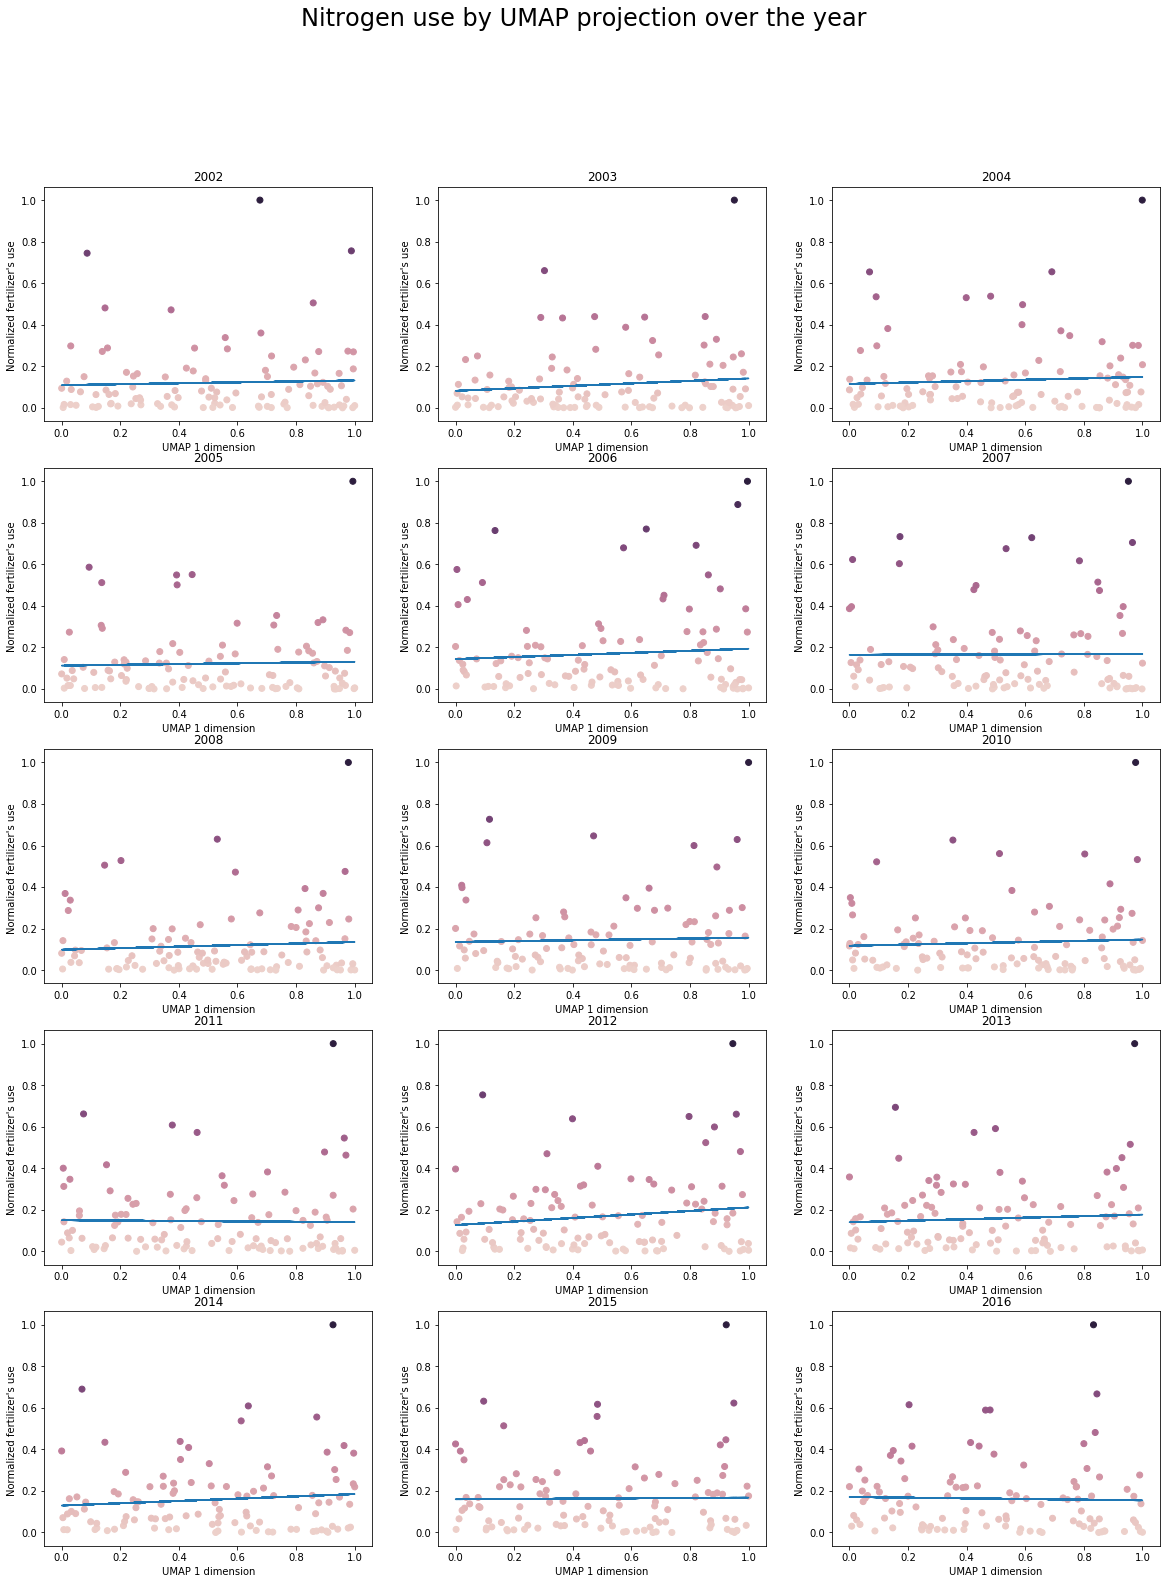

In [34]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3102, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2['Umap'], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2['Umap'], poly1d_fn(embedding2['Umap']))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")

The correlation between Umap and fertilizer use is weak.

LinregressResult(slope=-0.0011703902434752852, intercept=2.380266757563897, rvalue=-0.1948022828125585, pvalue=0.48660188838494034, stderr=0.0016344222432002373)
LinregressResult(slope=-0.008786635286960925, intercept=17.6240811754362, rvalue=-0.8525481630271708, pvalue=5.398691834327399e-05, stderr=0.0014939699037687152)
LinregressResult(slope=-0.00603792743210113, intercept=12.153567594547017, rvalue=-0.48573249714507505, pvalue=0.06641461320520715, stderr=0.003013588187479339)


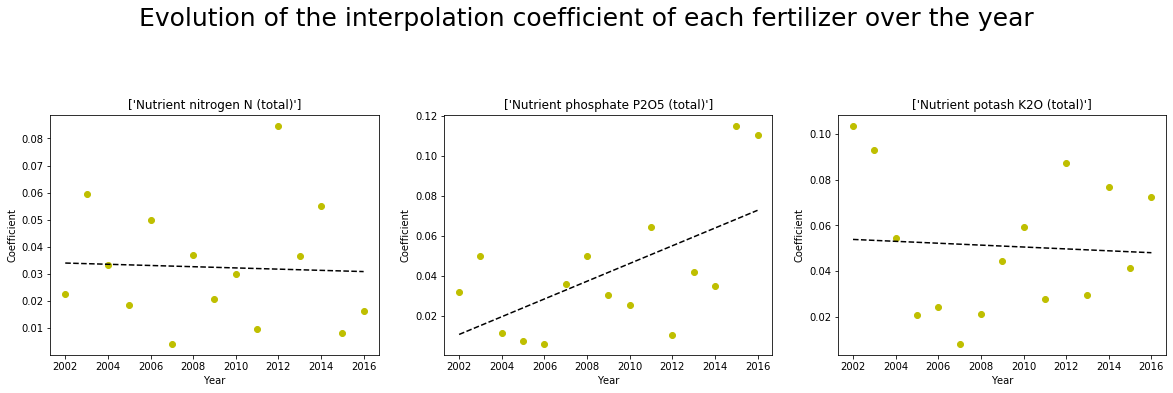

In [35]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        umap_result=umap_year(year,3102+x,1)
        mean.append([umap_result[0],umap_result[2][0]])
    mean=pd.DataFrame(mean)
    print(stats.linregress(mean[0],mean[1]))
    
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

In [36]:

def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge=yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_merge.reset_index(inplace=True)
    yield_for_merge=yield_for_merge.drop(columns=['index'])
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 

    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)

    embedding2=embedding2.join(yield_for_merge['Area'])

    #importation of fertilizer dataset
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')

    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    embedding2['ferti_norm']=(embedding2.Value-min(embedding2.Value))/(max(embedding2.Value)-min(embedding2.Value))
    coef = np.polyfit(embedding2['Umap'],embedding2.ferti_norm,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

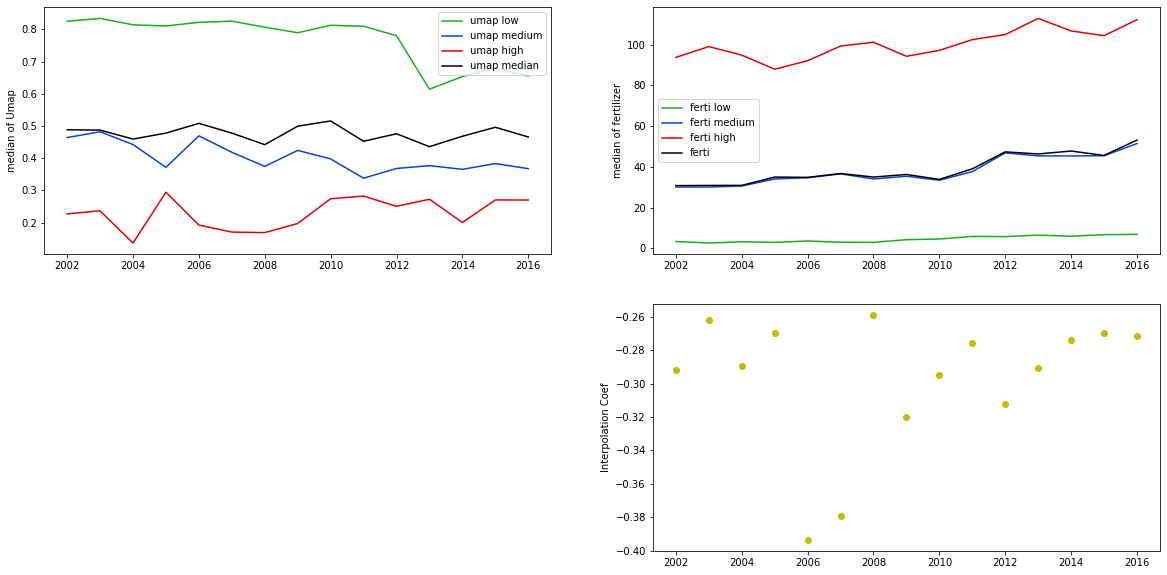

In [37]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    umap_result=umap_year(year,3102,1)
    low_median=umap_result[1].Value[umap_result[1].ferti_class=='low'].median()
    medium_median=umap_result[1].Value[umap_result[1].ferti_class=='medium'].median()
    high_median=umap_result[1].Value[umap_result[1].ferti_class=='high'].median()
    ferti_median=umap_result[1].Value.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].ferti_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].ferti_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].ferti_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,ferti_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','ferti low','ferti medium','ferti high','ferti',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "ferti low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "ferti medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "ferti high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "ferti", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

# PCA

In [38]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [39]:
def PCA_year(year, ferti_code):

    grouped_yield=crops.query('`Element Code` == 5419')\
    .query('`Year Code` == @year')\
    .query('`Item Code` >1000')\
    .query('`Area Code` <300')\
    .pivot(index='Area',columns='Item',values='Value')\
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
    .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reindex()
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])

    fertilizer=(fertilizer_area
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .query('`Item Code` == @ferti_code')
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.Value=(grouped_yield_pca.Value-min(grouped_yield_pca.Value))/(max(grouped_yield_pca.Value)-min(grouped_yield_pca.Value))
    
    
    
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)

    return year,grouped_yield_pca,coef # return year (for confirmation), performed PCA and value of linear regression

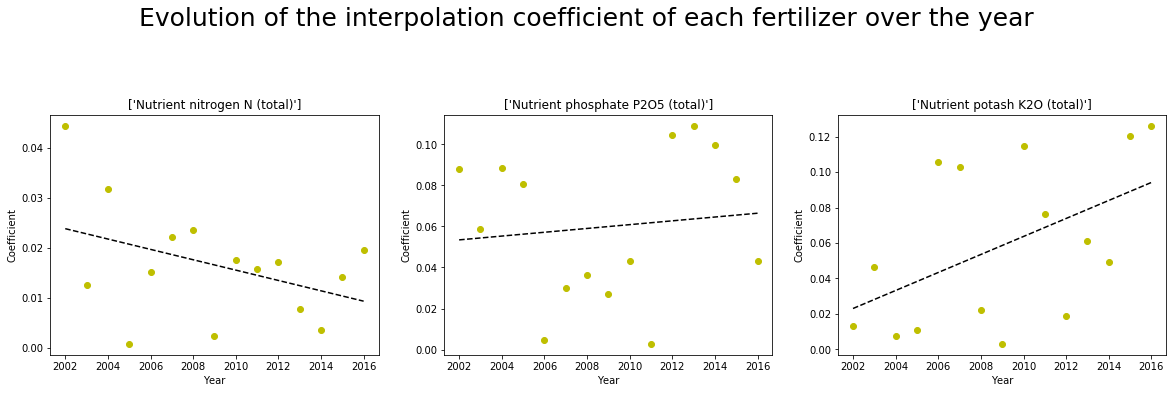

In [40]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        adding=PCA_year(year,3102+x)
        mean.append([adding[0],adding[2][0]])
    mean=pd.DataFrame(mean)
    
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

## Victor code modified ( normalization before polyfit and dropna added)

In [233]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
ferti_low = []
ferti_medium = []
ferti_high = []
ferti = []
fertilizer_effect = []
proportion_explained = []


for year in range(2002,2016+1):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
        .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
    )
    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))
    
    PC1_low += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'].median()]
    PC1_medium += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'].median()]
    PC1_high += [grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high'].median()]
    PC1 += [grouped_yield_pca.PC1.median()]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    ferti_low += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low'].median()]
    ferti_medium += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium'].median()]
    ferti_high += [grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high'].median()]
    
    ferti += [grouped_yield_pca.Value.median()]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    
    fertilizer_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

In [42]:
grouped_yield.head()

Item,Area,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary,Cereal
0,Afghanistan,89744,6586.77,3914.15,7443,130903,98165,19665.333333
1,Albania,214057,8354.46,6066.42,13829,242574,253610,51670.000000
2,Algeria,113518,10612.7,3366.65,10263,296099,205598,13558.333333
3,Angola,221328,2371.58,2464.85,5132,99626,33032,9771.000000
4,Argentina,175009,18864,4738.73,13537,246030,177960,52403.000000


Text(0, 0.5, 'fertilizer effect')

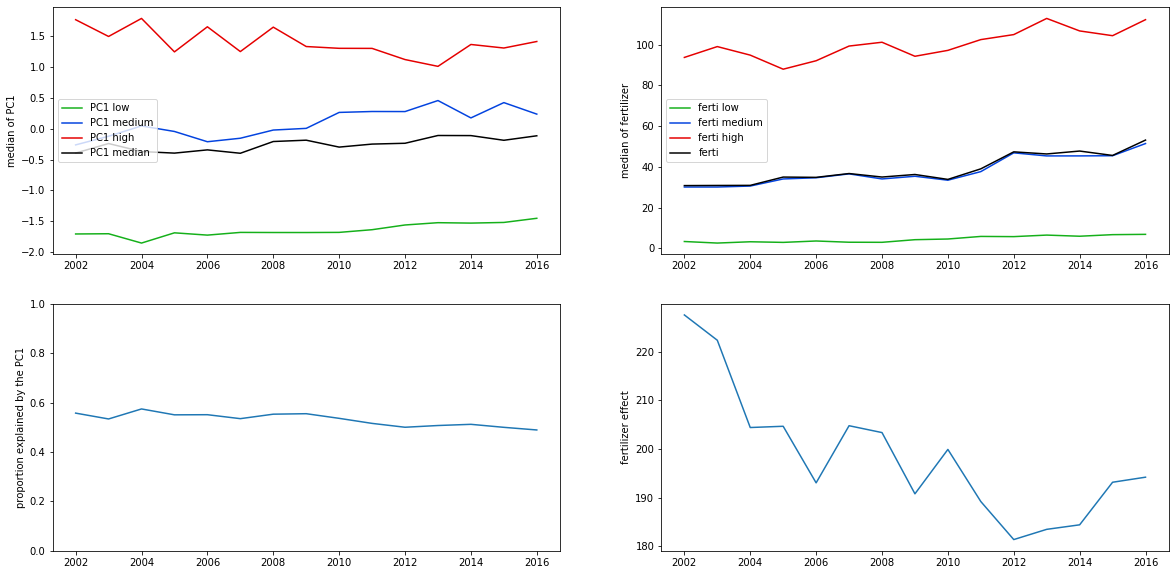

In [235]:
evolution_ferti = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, ferti_medium, ferti_high,ferti,PC1, proportion_explained, fertilizer_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','ferti low', 'ferti medium', 'ferti high','ferti','PC1 median', 'proportion explained', 'fertilizer_effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend(loc = 'center left')

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "ferti low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "ferti medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "ferti high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "ferti", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'fertilizer_effect', data=evolution_ferti)
ax4.set_ylabel('fertilizer effect')

# Boxplot ferti distrib over the years
(I was afraid that the tree groups median would become similar over the year (and thus making our visualization over the year for the 3 groups biased).
So here is visualization of fertilizer use distribution over the year

In [44]:
ferti_box=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    ferti=(fertilizer_area
            .query('`Year Code` == @year')
            .query('`Item Code` ==3102')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item Code',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    ferti.rename(columns={3102:str(year)},inplace=True)
    ferti['ferti_class'+str(year)]=ferti[str(year)].apply(lambda x: ferti_class(x, ferti[str(year)]))
    ferti.dropna(axis=0, inplace=True)
    ferti_box=ferti.merge(ferti_box,on='Area',how='outer')
    
ferti_box.head(1)

,Area,2016,ferti_class2016,2015,ferti_class2015,2014,ferti_class2014,2013,ferti_class2013,2012,...,2006,ferti_class2006,2005,ferti_class2005,2004,ferti_class2004,2003,ferti_class2003,2002,ferti_class2002
0,Afghanistan,11.71,low,11.71,low,11.71,low,14.45,low,27.58,...,6.2,low,3.17,low,2.96,low,2.57,low,3.02,low


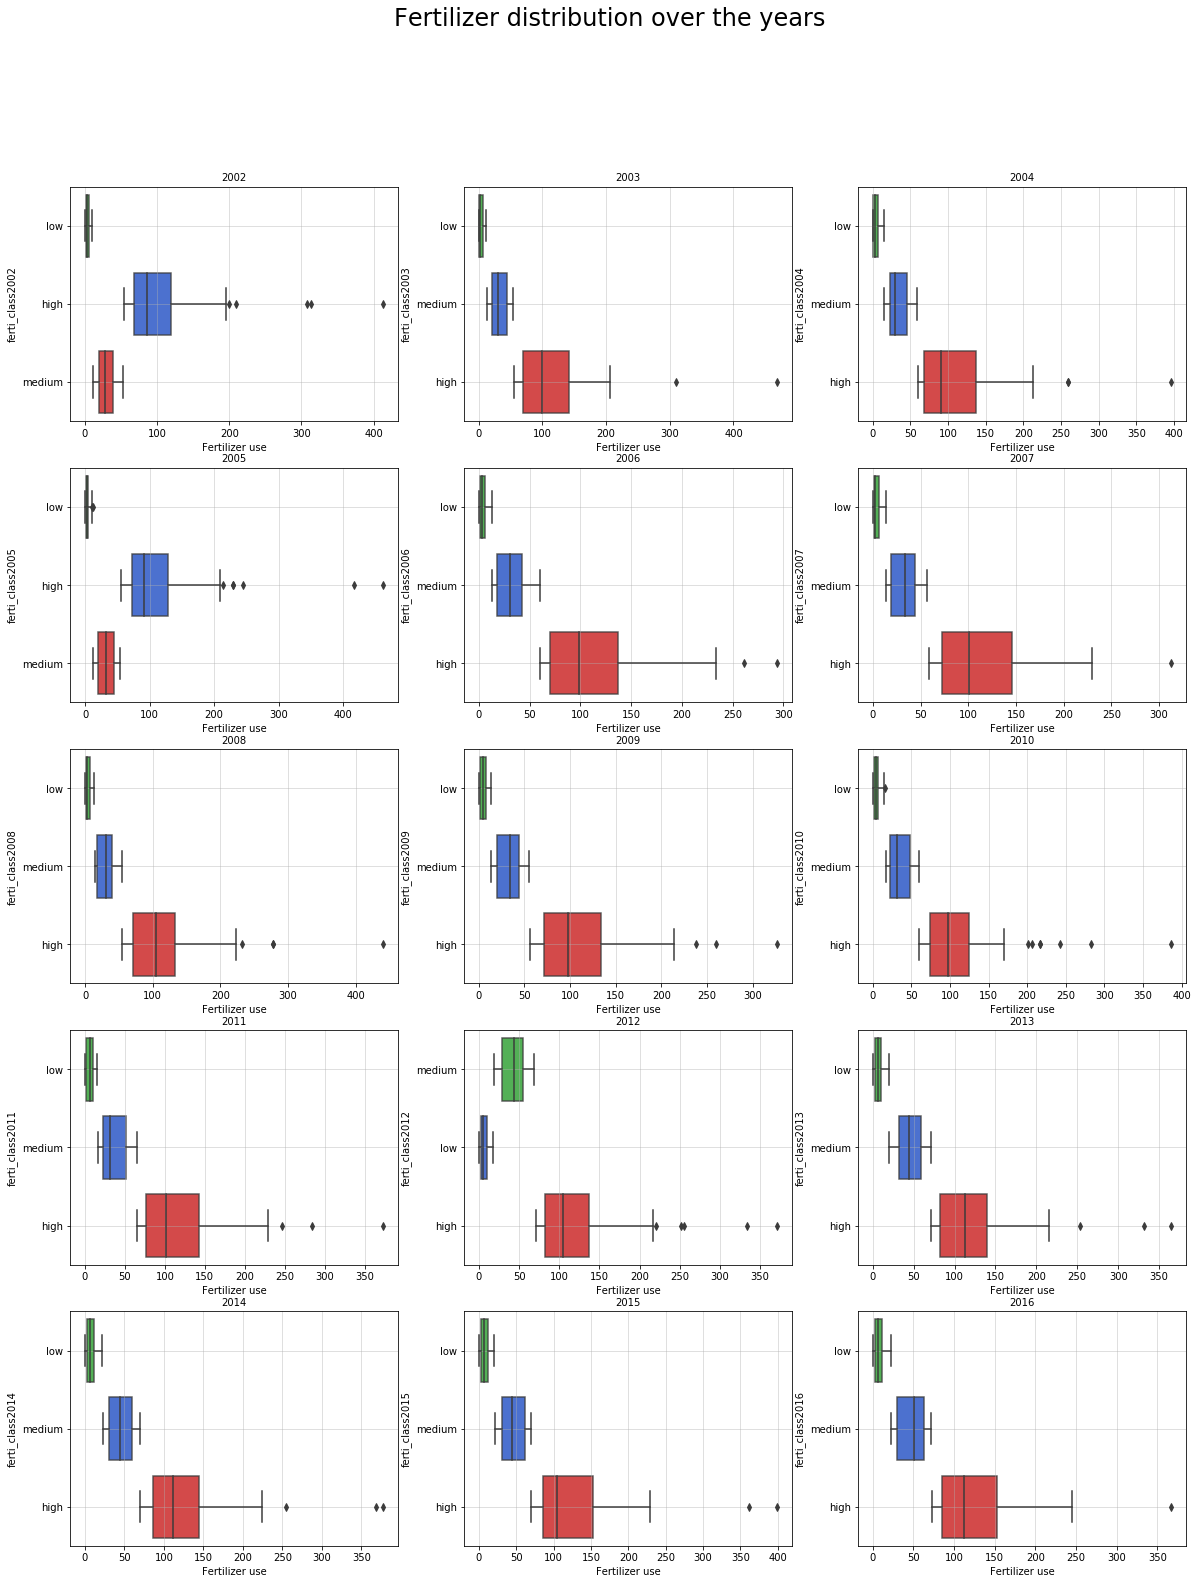

In [45]:
colors = ["green", "blue", "red"]
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Fertilizer distribution over the years', fontsize=24)
for x in range (n) : 
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    ax1 = sns.boxplot(x=str(x+2002), y='ferti_class'+str(x+2002), data=ferti_box, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
    ax1.grid(alpha=0.5)
    plt.xlabel('Fertilizer use')
    plt.title(str(x+2002), fontsize=10);

We can see that expect for year 2005 and 2012, the distribution stay similar. Thus it's correct to use median of the tree groups over the year as previously did

# Dataframe for map 

In [108]:
#yield dataframe
yield_indic=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    grouped_yield=(crops.query('`Element Code` == 5419')
    .query('`Year Code` == @year')
    .query('`Item Code` >1000')
    .query('`Area Code` <300')
    .pivot(index='Area',columns='Item',values='Value')
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])
    .reset_index()
    )

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    yield_indic=yield_indic.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
yield_indic.head(5)

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
1,Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243
2,Algeria,0.267123,0.257981,0.234186,0.242017,0.254120,0.213298,0.232459,0.261738,0.281083,0.305053,0.342455,0.352380,0.326843,0.330635,0.347874
3,Angola,0.168590,0.103734,0.085662,0.093193,0.095118,0.116208,0.118346,0.102838,0.108617,0.130947,0.087722,0.128989,0.126811,0.124678,0.128993
4,Argentina,0.541703,0.547322,0.458804,0.513677,0.534109,0.513240,0.501942,0.377790,0.498108,0.484524,0.476022,0.477465,0.469749,0.467691,0.470973


In [50]:
def replace_values_geojson(df):
    new_df = df
    new_df[new_df.Area == 'Russian Federation'] = df[df.Area == 'Russian Federation'].replace('Russian Federation', 'Russia')
    new_df[new_df.Area == 'Bolivia (Plurinational State of)'] = df[df.Area == 'Bolivia (Plurinational State of)'].replace('Bolivia (Plurinational State of)', 'Bolivia')
    new_df[new_df.Area == 'Venezuela (Bolivarian Republic of)'] = df[df.Area == 'Venezuela (Bolivarian Republic of)'].replace('Venezuela (Bolivarian Republic of)', 'Venezuela')
    new_df[new_df.Area == 'Côte d\'Ivoire'] = df[df.Area == 'Côte d\'Ivoire'].replace('Côte d\'Ivoire', 'Ivory Coast')
    new_df[new_df.Area == 'Congo'] = df[df.Area == 'Congo'].replace('Congo', 'Republic of the Congo')   
    new_df[new_df.Area == 'Republic of Moldova'] = df[df.Area == 'Republic of Moldova'].replace('Republic of Moldova', 'Moldova')
    new_df[new_df.Area == 'Syrian Arab Republic'] = df[df.Area == 'Syrian Arab Republic'].replace('Syrian Arab Republic', 'Syria')
    new_df[new_df.Area == 'Iran (Islamic Republic of)'] = df[df.Area == 'Iran (Islamic Republic of)'].replace('Iran (Islamic Republic of)', 'Iran')
    new_df[new_df.Area == 'Viet Nam'] = df[df.Area == 'Viet Nam'].replace('Viet Nam', 'Vietnam')
    new_df[new_df.Area == 'Lao People\'s Democratic Republic'] = df[df.Area == 'Lao People\'s Democratic Republic'].replace('Lao People\'s Democratic Republic', 'Laos')
    new_df[new_df.Area == 'Democratic People\'s Republic of Korea'] = df[df.Area == 'Democratic People\'s Republic of Korea'].replace('Democratic People\'s Republic of Korea', 'North Korea')
    new_df[new_df.Area == 'Republic of Korea'] = df[df.Area == 'Republic of Korea'].replace('Republic of Korea', 'South Korea')
    new_df[new_df.Area == 'Serbia'] = df[df.Area == 'Serbia'].replace('Serbia', 'Republic of Serbia')
    new_df[new_df.Area == 'The former Yugoslav Republic of Macedonia'] = df[df.Area == 'The former Yugoslav Republic of Macedonia'].replace('The former Yugoslav Republic of Macedonia', 'Macedonia')
    new_df[new_df.Area == 'China, Taiwan Province of'] = df[df.Area == 'China, Taiwan Province of'].replace('China, Taiwan Province of', 'Taiwan')
    return(new_df)

In [51]:
# Load the GeoJson file containing the name, id and geometry of each country
df = gpd.read_file("./countries.geo.json")

# Make some changes in the names of the countries in the dataset to make them match with the GeoJson file
yield_indic2 = replace_values_geojson(yield_indic)

# Make sure that the name of the countries in your dataframe is 'name' as in the GeoJson file
yield_indic2 = yield_indic.rename(columns={'Area': 'name'})

# Merge the geometry of the countries to the yield DataFrame
yield_indic2.drop_duplicates(inplace=True)
df_final = df.merge(yield_indic2, on='name', how='left')

# Here, you should have a dataframe with a column name, a column id, a column geometry, and one column per year per the infrmation you want to show
# Plot the production on an interactive map
years = range(2002,2017) # Check that it corresponds to your year range     
slider_columns = [str(i) for i in years]  # Replace it with the names of your column( should be given as a list)

yield_map = df_final.plot_bokeh(
            figsize = (900,600),
            simplify_shapes=10000,
            slider = slider_columns,
            slider_range = years,
            slider_name = 'Year',
            colormap = 'Inferno',
            hovertool_columns = ['id']+slider_columns,
            title='Yield PCA over the year'
            )

output_file("carte_yield_pca.html")
save(yield_map)

'C:\\Users\\juleb\\Documents\\fac_toto\\ADA\\ada_project-ada_nakamura\\carte_yield_pca.html'

In [52]:
# UMAP dataset
umap_indic=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    umap_df=umap_year(year, 3102, 1)[1]
    umap_df.rename(columns={'Umap':str(year)},inplace=True)
    umap_indic=umap_indic.merge(umap_df.loc[:,['Area',str(year)]], on='Area',how='outer')
umap_indic.head()

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,0.469523,0.454908,0.438383,0.512272,0.581635,0.479684,0.493458,0.721297,0.787998,0.767241,0.755794,0.465407,0.489405,0.572137,0.470352
1,Albania,0.576411,0.518710,0.611284,0.585204,0.310196,0.283442,0.254457,0.171466,0.179564,0.228245,0.231434,0.398719,0.217392,0.294203,0.213252
2,Algeria,0.486355,0.423397,0.456301,0.438686,0.498888,0.467434,0.388726,0.466471,0.511911,0.314669,0.304750,0.367450,0.207882,0.321806,0.194773
3,Angola,0.786281,0.714811,0.793648,0.747171,0.798860,0.719748,0.676579,0.730406,0.746202,0.699875,0.708499,0.581598,0.645985,0.682577,0.000000
4,Argentina,0.126733,0.133453,0.190617,0.143105,0.097196,0.113606,0.088172,0.149171,0.109270,0.109384,0.125979,0.111461,0.112656,0.147994,0.269063


In [53]:
#ferti dataframe
ferti_year=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    ferti=(fertilizer_area
            .query('`Year Code` == @year')
            .query('`Item Code` ==3102')
            .query('`Area Code` <300')
            .pivot(index='Area',columns='Item Code',values='Value')
            .dropna(axis=0)
            .reset_index()
              )
    ferti.rename(columns={3102:str(year)},inplace=True)
    ferti.dropna(axis=0, inplace=True)
    
    ferti_year=ferti.merge(ferti_year,on='Area',how='outer')
ferti_year.head(5)

,Area,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,11.71,11.71,11.71,14.45,27.58,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.96,2.57,3.02
1,Albania,60.98,52.87,44.13,44.11,49.95,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.19,53.15,54.34
2,Algeria,11.53,11.83,12.25,7.79,7.89,7.51,8.43,5.69,2.75,4.37,5.23,0.49,12.62,2.07,3.42
3,Angola,4.89,4.91,5.32,3.94,3.89,3.28,3.96,2.44,2.21,1.51,1.85,1.03,2.00,0.50,0.81
4,Antigua and Barbuda,8.76,1.70,4.12,6.48,5.34,0.80,0.80,4.60,1.80,0.40,1.80,3.40,0.00,6.60,2.00


# Rank 5 better countries :


In [54]:
# Rank by PCA score
yield_indic.sort_values(by='2011',ascending=False).loc[:,['Area','2009']].head(5)


,Area,2009
75,Ireland,0.807159
103,Netherlands,1.000000
13,Belgium,0.949627
142,Switzerland,0.793517
155,United Kingdom,0.727374


In [55]:
# Rank by Umap score
umap_result=umap_year(2009,3102,1)
umap_result[1].sort_values(by='Umap',ascending=False).loc[:,['Area','Umap']].head(5)

,Area,Umap
28,Colombia,1.000000
43,Eritrea,0.950111
137,Zimbabwe,0.949296
83,Mozambique,0.949093
50,Gambia,0.927106


In [56]:
# Rank by fertilizer use
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == 2009')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )
fertilizer.loc[:,['Area','Value']].head(5)

,Area,Value
832,Egypt,326.82
2632,United Arab Emirates,259.73
562,"China, mainland",237.47
1912,Oman,213.82
1447,Luxembourg,211.34


The only value shared by both dataframes is Egypt which has the better place (but only using the Umap ranking). It correspond to the black point on the diagram "Nitrogen Use by umap projection over the year" previously displayed (in the Umap part).

# Fertilizer use vs PCA or UMAP over the years

In [59]:
# This function separates countries in tree different groups according to their fertilizer's use
def ferti_color(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizers values'''
    if x<np.percentile(L,33):
        return 'green'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'orange'
    else:
        return 'red'

In [168]:
#yield dataframe
pca_ferti_frame=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    grouped_yield=(crops.query('`Element Code` == 5419')
    .query('`Year Code` == @year')
    .query('`Item Code` >1000')
    .query('`Area Code` <300')
    .pivot(index='Area',columns='Item',values='Value')
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])
    .reset_index()
    )

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    pca_ferti_frame=pca_ferti_frame.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
    
    ferti=(fertilizer_area
        .query('`Year Code` == @year')
        .query('`Item Code` ==3102')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item Code',values='Value')
        .dropna(axis=0)
        .reset_index()
          )
    ferti.rename(columns={3102:str(year)+'_ferti'},inplace=True)
    ferti.dropna(axis=0, inplace=True)
    ferti['ferti_color_'+str(year)]=ferti[str(year)+'_ferti'].apply(lambda x: ferti_color(x, ferti[str(year)+'_ferti']))
    pca_ferti_frame=pca_ferti_frame.merge(ferti.loc[:,['Area',str(year)+'_ferti','ferti_color_'+str(year)]], on='Area',how='left')
pca_ferti_frame.head(5)

,Area,2002,2002_ferti,ferti_color_2002,2003,2003_ferti,ferti_color_2003,2004,2004_ferti,ferti_color_2004,...,ferti_color_2013,2014,2014_ferti,ferti_color_2014,2015,2015_ferti,ferti_color_2015,2016,2016_ferti,ferti_color_2016
0,Afghanistan,-0.814322,3.02,green,-0.815293,2.57,green,-0.905765,2.96,green,...,green,-1.149030,11.71,green,-1.260170,11.71,green,-1.359291,11.71,green
1,Albania,0.462978,54.34,red,0.168131,53.15,orange,0.062443,51.19,orange,...,orange,1.250716,44.13,orange,1.277543,52.87,orange,1.374337,60.98,orange
2,Algeria,-0.778872,3.42,green,-0.376293,2.07,green,-0.516225,12.62,green,...,green,0.202174,12.25,green,0.281118,11.83,green,0.287093,11.53,green
3,Angola,-1.741561,0.81,green,-1.747918,0.50,green,-1.918447,2.00,green,...,green,-1.543238,5.32,green,-1.591230,4.91,green,-1.626394,4.89,green
4,Argentina,1.903843,18.52,orange,2.196640,24.95,orange,1.604389,25.06,orange,...,green,1.449124,19.67,green,1.527095,14.52,green,1.363239,22.53,orange


In [88]:
# Create dataframe of linear interpolation over the years
interpo_data=pd.DataFrame(index=[1,2])
yield_interp=pca_ferti_frame.dropna(axis=0)
for year in range(2002,2016+1,1):
    par = np.polyfit(yield_interp[str(year)], yield_interp[str(year)+'_ferti'], 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    x=[min(yield_interp[str(year)]), max(yield_interp[str(year)])]
    y_predicted = [slope*min(yield_interp[str(year)]) + intercept, slope*max(yield_interp[str(year)]) + intercept]
    interpo_data['x_'+str(year)] = x
    interpo_data['y_'+str(year)] = y_predicted
interpo_data

,x_2002,y_2002,x_2003,y_2003,x_2004,y_2004,x_2005,y_2005,x_2006,y_2006,...,x_2012,y_2012,x_2013,y_2013,x_2014,y_2014,x_2015,y_2015,x_2016,y_2016
1,-3.388731,-29.461652,-2.670364,-14.365059,-2.727179,-6.709779,-2.730583,-10.465113,-2.648260,-8.044797,...,-2.598181,0.882828,-2.647327,1.124593,-2.649745,1.063387,-2.724674,-1.037223,-2.754072,-1.226322
2,6.381528,198.143196,6.222031,208.029530,6.713823,197.716000,6.541774,194.218018,6.187189,184.988274,...,6.028353,182.239521,6.116709,184.587173,6.075917,185.455168,6.077624,192.120573,5.988065,192.973586


In [218]:
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider, tickers
from bokeh.plotting import Figure, show
from bokeh.models.tickers import ContinuousTicker,FixedTicker,SingleIntervalTicker

# fetch and clear the document
from bokeh.io import curdoc
curdoc().clear()


source = ColumnDataSource(pca_ferti_frame)

yield_interp=pca_ferti_frame.dropna(axis=0)
par = np.polyfit(yield_interp['2002'], yield_interp['2002_ferti'], 1, full=True)
slope=par[0][0]
intercept=par[0][1]
y_predicted = [slope*min(yield_interp['2002']) + intercept, slope*max(yield_interp['2002']) + intercept]


interpo = ColumnDataSource(interpo_data)

plot = Figure(plot_width=400, plot_height=400)
plot.circle(x='2002', y='2002_ferti', source=source, size=6, color="ferti_color_2002", alpha=0.5)
plot.line(x='x_2002',y='y_2002',source=interpo)


plot.xaxis.axis_label = "Agriculture indicator score"
plot.yaxis.axis_label = "Fertilizer use"
plot.xaxis.ticker = SingleIntervalTicker(interval=1,num_minor_ticks=0)
plot.yaxis.ticker = SingleIntervalTicker(interval=100,num_minor_ticks=0)
# = np.linspace(0,1,6)

def callback(source=source, window=None):
    data = source.data
    f = cb_obj.value
    
    x, y, z = data['2002'], data['2002_ferti'], data['ferti_color_2002']
    e, g, h = data[f], data[f+'_ferti'], data['ferti_color_'+f]
    for i in range(len(x)):
        x[i] = e[i]
        y[i] = g[i]
        z[i] = h[i]
        
    source.change.emit()
    
def callback2(source=interpo, window=None):
    data = source.data
    f = cb_obj.value
    
    a,b = data['x_2002'], data['y_2002']
    
    for i in range(2):
        a[i] = data['x_'+f][i]
        b[i] = data['y_'+f][i]
    
    source.change.emit()
    

slider = Slider(start=2002, end=2016, value=2002, step=1, title="power"
                )#,callback=CustomJS.from_py_func(callback)

slider.js_on_change('value', CustomJS.from_py_func(callback))
slider.js_on_change('value', CustomJS.from_py_func(callback2))
layout = column(slider, plot)

show(layout)
output_file("pca_ferti_year.html")
save(layout)

'C:\\Users\\juleb\\Documents\\fac_toto\\ADA\\ada_project-ada_nakamura\\pca_ferti_year.html'

# Try plot evolution with small groups


In [169]:
pca_ferti_frame.head(5)

,Area,2002,2002_ferti,ferti_color_2002,2003,2003_ferti,ferti_color_2003,2004,2004_ferti,ferti_color_2004,...,ferti_color_2013,2014,2014_ferti,ferti_color_2014,2015,2015_ferti,ferti_color_2015,2016,2016_ferti,ferti_color_2016
0,Afghanistan,-0.814322,3.02,green,-0.815293,2.57,green,-0.905765,2.96,green,...,green,-1.149030,11.71,green,-1.260170,11.71,green,-1.359291,11.71,green
1,Albania,0.462978,54.34,red,0.168131,53.15,orange,0.062443,51.19,orange,...,orange,1.250716,44.13,orange,1.277543,52.87,orange,1.374337,60.98,orange
2,Algeria,-0.778872,3.42,green,-0.376293,2.07,green,-0.516225,12.62,green,...,green,0.202174,12.25,green,0.281118,11.83,green,0.287093,11.53,green
3,Angola,-1.741561,0.81,green,-1.747918,0.50,green,-1.918447,2.00,green,...,green,-1.543238,5.32,green,-1.591230,4.91,green,-1.626394,4.89,green
4,Argentina,1.903843,18.52,orange,2.196640,24.95,orange,1.604389,25.06,orange,...,green,1.449124,19.67,green,1.527095,14.52,green,1.363239,22.53,orange


In [175]:
#yield dataframe
yield_indic=pd.DataFrame(columns=['Area'])
for year in fertilizer_area.pivot_table(index=['Year Code']).index :
    grouped_yield=(crops.query('`Element Code` == 5419')
    .query('`Year Code` == @year')
    .query('`Item Code` >1000')
    .query('`Area Code` <300')
    .pivot(index='Area',columns='Item',values='Value')
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])
    .reset_index()
    )

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    yield_indic=yield_indic.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
yield_indic.head(5)

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,-0.814322,-0.815293,-0.905765,-1.064105,-1.041572,-1.010634,-1.251264,-1.196547,-1.447593,-1.380109,-1.195975,-1.060130,-1.149030,-1.260170,-1.359291
1,Albania,0.462978,0.168131,0.062443,0.354013,0.567506,0.494160,0.658879,0.922946,1.270624,1.206188,1.191146,1.198660,1.250716,1.277543,1.374337
2,Algeria,-0.778872,-0.376293,-0.516225,-0.486515,-0.485579,-0.728648,-0.612466,-0.153435,-0.043780,0.085726,0.286283,0.350393,0.202174,0.281118,0.287093
3,Angola,-1.741561,-1.747918,-1.918447,-1.866464,-1.908032,-1.626757,-1.652783,-1.713496,-1.690234,-1.491864,-1.938193,-1.638652,-1.543238,-1.591230,-1.626394
4,Argentina,1.903843,2.196640,1.604389,2.032415,2.019250,2.045905,1.844302,0.985951,2.028071,1.711938,1.452667,1.464125,1.449124,1.527095,1.363239


In [176]:
# First lets take 5 samples of each group 
# But countries has to be in the same group over the years
same_group_countries=pca_ferti_frame.loc[:,['Area','ferti_color_2002']]
same_group_countries.rename(columns={"ferti_color_2002": "group"}, inplace=True)
print(same_group_countries.shape[0])
for year in range (2002,2016+1,1):
    search= 'ferti_color_'+str(year)
    to_intersect = pca_ferti_frame.loc[:,['Area','ferti_color_'+str(year)]]
    to_intersect.rename(columns={'ferti_color_'+str(year): "group"}, inplace=True)
    same_group_countries=pd.merge(same_group_countries, to_intersect)
print(same_group_countries.shape[0])

167
101


In [224]:
high_sample=same_group_countries.query('group == "red"').sample(n=29).Area
low_sample=same_group_countries.query('group == "green"').sample(n=13).Area
med_sample=same_group_countries.query('group == "orange"').sample(n=13).Area

In [225]:
high_yield = yield_indic[yield_indic.Area.isin(high_sample.values)]
high_ferti = ferti_year[ferti_year.Area.isin(high_sample.values)]
high_yield=high_yield.set_index('Area').T
high_ferti=high_ferti.set_index('Area').T
high_values = pd.merge(high_ferti,high_yield, left_index=True, right_index=True, suffixes=('_ferti', '_pca')) 

med_yield = yield_indic[yield_indic.Area.isin(med_sample.values)]
med_ferti = ferti_year[ferti_year.Area.isin(med_sample.values)]
med_yield=med_yield.set_index('Area').T
med_ferti=med_ferti.set_index('Area').T
med_values = pd.merge(med_ferti,med_yield, left_index=True, right_index=True, suffixes=('_ferti', '_pca')) 

low_yield = yield_indic[yield_indic.Area.isin(low_sample.values)]
low_ferti = ferti_year[ferti_year.Area.isin(low_sample.values)]
low_yield=low_yield.set_index('Area').T
low_ferti=low_ferti.set_index('Area').T
low_values = pd.merge(low_ferti,low_yield, left_index=True, right_index=True, suffixes=('_ferti', '_pca')) 


In [226]:
plot = Figure(plot_width=400, plot_height=400)

high_plot = ColumnDataSource(high_values)
med_plot = ColumnDataSource(med_values)
low_plot = ColumnDataSource(low_values)

for area in high_sample.values :
    plot.line(x=area+'_ferti', y=area+'_pca', color="red", source=high_plot)
for area in med_sample.values :
    plot.line(x=area+'_ferti', y=area+'_pca', color=Colorblind[6][3], source=med_plot)
for area in low_sample.values :
    plot.line(x=area+'_ferti', y=area+'_pca', color="green", source=low_plot)

show(plot)

Interesting !!!

In [212]:
Colorblind[6][3]


'#009E73'

In [236]:
from bokeh.layouts import column, row
from bokeh.palettes import Colorblind

#create figure and add legends
pcaplot = Figure(plot_width=400, plot_height=400)
pcaplot.xaxis.axis_label = "Year"
pcaplot.yaxis.axis_label = "Agriculture indicator score"
pcaplot.xaxis.ticker = SingleIntervalTicker(interval=2,num_minor_ticks=1)
pcaplot.yaxis.ticker = SingleIntervalTicker(interval=2,num_minor_ticks=1)

ferplot = Figure(plot_width=400, plot_height=400)
ferplot.xaxis.axis_label = "Year"
ferplot.yaxis.axis_label = "Fertilizer use"
ferplot.xaxis.ticker = SingleIntervalTicker(interval=2,num_minor_ticks=1)
ferplot.yaxis.ticker = SingleIntervalTicker(interval=100,num_minor_ticks=0)

#import data
high_plot = ColumnDataSource(high_values)
med_plot = ColumnDataSource(med_values)
low_plot = ColumnDataSource(low_values)
median_plot = ColumnDataSource(evolution_ferti)

# add curves
for area in high_sample.values : #for high fertilizer use
    pcaplot.line(x='index', y=area+'_pca', color=Colorblind[6][5], line_width=1, line_alpha=0.4, source=high_plot)
    ferplot.line(x='index', y=area+'_ferti', color=Colorblind[6][5], line_width=1, line_alpha=0.4, source=high_plot)
for area in med_sample.values : #for medium fertilizer use
    pcaplot.line(x='index', y=area+'_pca', color=Colorblind[6][3], line_width=1, line_alpha=0.4, source=med_plot)
    ferplot.line(x='index', y=area+'_ferti', color=Colorblind[6][3], line_width=1, line_alpha=0.4, source=med_plot)
for area in low_sample.values : #for low fertilizer use
    ferplot.line(x='index', y=area+'_ferti', color=Colorblind[6][2], line_width=1, line_alpha=0.4, source=low_plot)
    pcaplot.line(x='index', y=area+'_pca', color=Colorblind[6][2], line_width=1, line_alpha=0.4, source=low_plot)

#medium value for each group
ferplot.line(x='year', y='ferti high', color=Colorblind[6][5], line_width=5,line_dash='dashed' , source=median_plot)
ferplot.line(x='year', y='ferti medium', color=Colorblind[6][3], line_width=5,line_dash='dashed' , source=median_plot)
ferplot.line(x='year', y='ferti low', color=Colorblind[6][2], line_width=5 ,line_dash='dashed' , source=median_plot)

pcaplot.line(x='year', y='PC1 high', color=Colorblind[6][5], line_width=5 , source=median_plot)
pcaplot.line(x='year', y='PC1 medium', color='#01805d', line_width=5 , source=median_plot)
pcaplot.line(x='year', y='PC1 low', color='#f0cb42', line_width=5 , source=median_plot)


layout = row(pcaplot, ferplot)
show(layout)

In [162]:
evolution_ferti.head()

,year,PC1 low,PC1 medium,PC1 high,ferti low,ferti medium,ferti high,ferti,PC1 median,proportion explained,fertilizer_effect
0,2002.0,-1.703146,-0.262735,1.761450,3.345,30.11,93.78,30.815,-0.394680,0.557201,227.604848
1,2003.0,-1.699258,-0.123179,1.490429,2.580,30.11,99.11,30.880,-0.241010,0.533566,222.394589
2,2004.0,-1.850069,0.043621,1.782009,3.215,30.59,94.91,30.925,-0.370443,0.574098,204.425778
3,2005.0,-1.684625,-0.045746,1.241176,2.910,34.08,88.00,35.000,-0.395701,0.550268,204.683131
4,2006.0,-1.721564,-0.211738,1.646915,3.595,34.66,92.15,34.860,-0.343469,0.550803,193.033072


,year,PC1 low,PC1 medium,PC1 high,ferti low,ferti medium,ferti high,ferti,PC1 median,proportion explained,fertilizer_effect
0,2002.0,-1.703146,-0.262735,1.761450,3.345,30.11,93.78,30.815,-0.394680,0.557201,227.604848
1,2003.0,-1.699258,-0.123179,1.490429,2.580,30.11,99.11,30.880,-0.241010,0.533566,222.394589
2,2004.0,-1.850069,0.043621,1.782009,3.215,30.59,94.91,30.925,-0.370443,0.574098,204.425778
3,2005.0,-1.684625,-0.045746,1.241176,2.910,34.08,88.00,35.000,-0.395701,0.550268,204.683131
4,2006.0,-1.721564,-0.211738,1.646915,3.595,34.66,92.15,34.860,-0.343469,0.550803,193.033072
5,2007.0,-1.677837,-0.155168,1.246184,2.985,36.57,99.37,36.735,-0.398106,0.534812,204.796910
6,2008.0,-1.679463,-0.022726,1.640965,2.945,34.08,101.24,35.015,-0.208281,0.552916,203.384786
7,2009.0,-1.679780,0.004392,1.327673,4.235,35.40,94.35,36.270,-0.186718,0.554840,190.775909
8,2010.0,-1.677524,0.262335,1.298752,4.570,33.46,97.25,33.855,-0.298441,0.536069,199.915725
9,2011.0,-1.634040,0.277092,1.297504,5.840,37.68,102.54,39.045,-0.249770,0.515642,189.186632
